In [1]:
import requests
import s3fs
from pprint import pprint
import xarray as xr
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from tqdm import tqdm
import pyresample as pr
from pyresample.kd_tree import resample_gauss

#to make big figures
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
#select L2 data: 
# dataset='podaac-ops-cumulus-protected/MODIS_T-JPL-L2P-v2019.0' #this dataset can't be concatenated like that as dimensions in metadata is reversed
# shortname='MODIS_T-JPL-L2P-v2019.0'
dataset='podaac-ops-cumulus-protected/VIIRS_NPP-OSPO-L2P-v2.61'
shortname = 'VIIRS_NPP-OSPO-L2P-v2.61' 

#timeframe of interest:
start_date = '2015-09-15T00:00:00Z'
end_date   = '2015-09-15T23:59:59Z'

#region of interest:
lonmin = -170.0
latmin = 65.0
lonmax = -120.0
latmax = 80.0

In [3]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'
url = f'{CMR_OPS}/{"collections"}'

In [4]:
provider = 'POCLOUD'
response = requests.get(url,
                        params={
                            'short_name': shortname,
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 251,
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
collections = response.json()['feed']['entry']
for collection in collections:
    print(f'{collection["archive_center"]} {collection["dataset_id"]} {collection["id"]}')

NASA/JPL/PODAAC GHRSST Level 2P OSPO dataset v2.61 from VIIRS on S-NPP Satellite (GDS v2) C1996880725-POCLOUD


In [5]:
# concept_id='C1940475563-POCLOUD' #get the concept ID from earthdata website, clicking on the dataset, looking at the http link: https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2075141524-POCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&q=L2&ff=Available%20from%20AWS%20Cloud&fi=ASCAT&fl=2%20-%20Geophys.%20Variables%2C%20Sensor%20Coordinates&tl=1637188235.263!3!!&m=8.456485070842092!-75.234375!1!1!0!0%2C2
concept_id='C1996880725-POCLOUD'
url = f'{CMR_OPS}/{"granules"}'
spacebox=str(lonmin)+','+str(latmin)+','+str(lonmax)+','+str(latmax) #SW lon, SW lat, NE lon, NE lat
tempbox=f'{start_date},{end_date}'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': tempbox,
                            'bounding_box': spacebox,
                            'page_size': 228,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response.status_code)
print(response.headers['cmr-hits'])

200
21


In [6]:
granules = response.json()['feed']['entry']
urls = []
for granule in granules:
    # print(granule['boxes'], granule['links'][0]['href'])
    urls.append(granule['links'][0]['href'])
pprint(urls[0])
pprint(urls[1])

's3://podaac-ops-cumulus-protected/VIIRS_NPP-OSPO-L2P-v2.61/20150915004000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0.nc'
's3://podaac-ops-cumulus-protected/VIIRS_NPP-OSPO-L2P-v2.61/20150915005000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0.nc'


In [7]:
#s3fs
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials'}

def get_temp_creds():
    temp_creds_url = s3_cred_endpoint['podaac']
    return requests.get(temp_creds_url).json()

temp_creds_req = get_temp_creds()

s3_client = s3fs.S3FileSystem(anon=False,key=temp_creds_req['accessKeyId'], secret=temp_creds_req['secretAccessKey'], token=temp_creds_req['sessionToken'])

In [8]:
ds = xr.open_dataset(s3_client.open('podaac-ops-cumulus-protected/VIIRS_NPP-OSPO-L2P-v2.61/20150915004000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0.nc'), decode_cf=True) #issue when trying to open because of some CF conventions (?) so we add decode_cf=False
ds

<xarray.Dataset>
Dimensions:                       (time: 1, nj: 5392, ni: 3200)
Coordinates:
  * time                          (time) datetime64[ns] 2015-09-15T00:40:01
    lat                           (nj, ni) float32 ...
    lon                           (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sst_dtime                     (time, nj, ni) timedelta64[ns] ...
    dt_analysis                   (time, nj, ni) float32 ...
    satellite_zenith_angle        (time, nj, ni) float32 ...
    sea_surface_temperature       (time, nj, ni) float32 ...
    sses_bias                     (time, nj, ni) float32 ...
    sses_standard_deviation       (time, nj, ni) float32 ...
    ...                            ...
    quality_level                 (time, nj, ni) float32 ...
    wind_speed                    (time, nj, ni) float32 ...
    brightness_temperature_11um   (time, nj, ni) float32 ...
    brightness_temperature_12um   (time, nj, ni) float32 ...
    brightness_temperature_4um    (time, nj, ni) float32 ...
    brightness_temperature_08um6  (time, nj, ni) float32 ...
Attributes: (12/60)
    geospatial_bounds:                        POLYGON((-130.275  81.715, -156...
    geospatial_first_scanline_first_fov_lat:  [48.642075]
    geospatial_first_scanline_first_fov_lon:  [-156.7573]
    geospatial_first_scanline_last_fov_lat:   [42.756565]
    geospatial_first_scanline_last_fov_lon:   [164.09525]
    geospatial_last_scanline_first_fov_lat:   [81.71458]
    ...                                       ...
    time_coverage_end:                        20150915T004959Z
    time_coverage_start:                      20150915T004001Z
    title:                                    VIIRS L2P SST
    uuid:                                     5cb6e4ce-54a9-11e9-bfab-ac1f6b5...
    westernmost_longitude:                    [115.576836]
    netcdf_version_id:                        4.5.0 of Oct 31 2017 11:38:27 $

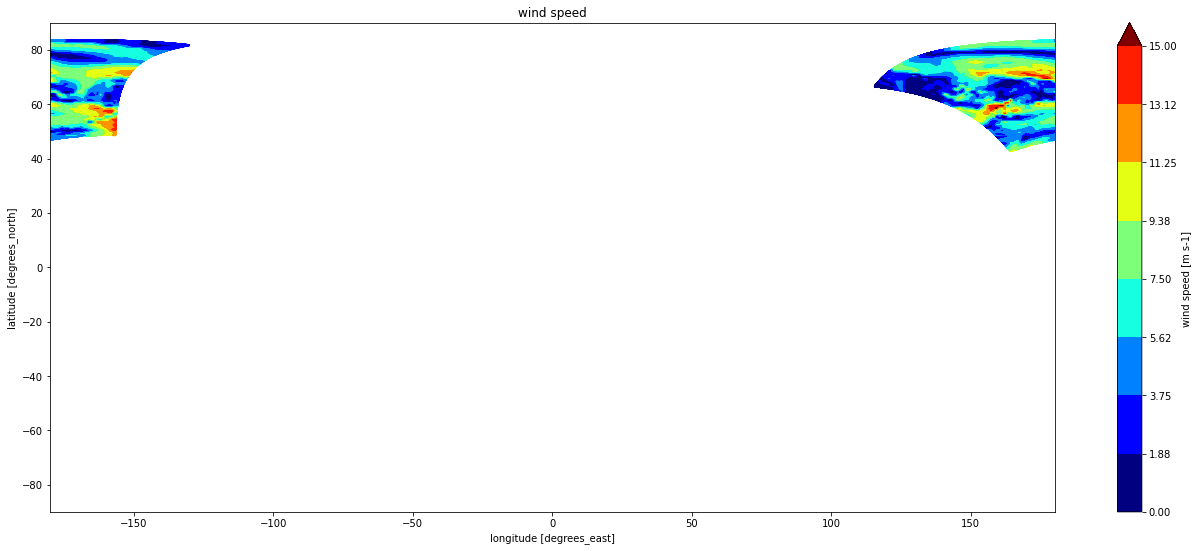

In [10]:
#plot 1 file - wind speed
ds.plot.scatter( y="lat",
                 x="lon", 
                 hue="wind_speed",
                 s=1,
                 vmin=0,
                 vmax=15,
                 levels=9, 
                 cmap="jet",
                 aspect=2.5,
                 size=9, )

plt.title(f'wind speed')
plt.xlim(  -180., 180.)
plt.ylim(-90.,  90.)
plt.show()

In [12]:
#stack the files
fileset = [s3_client.open(file) for file in urls[0:2]]
ds_stacked = xr.open_mfdataset(fileset, combine='by_coords',
                               decode_cf=True,)
                               # preprocess=lambda x: x.isel(time=0))
ds_stacked

<xarray.Dataset>
Dimensions:                       (time: 2, nj: 5392, ni: 3200)
Coordinates:
  * time                          (time) datetime64[ns] 2015-09-15T00:40:01 2...
    lat                           (time, nj, ni) float32 48.64 48.64 ... 53.56
    lon                           (time, nj, ni) float32 -156.8 -156.8 ... 44.98
Dimensions without coordinates: nj, ni
Data variables: (12/14)
    sst_dtime                     (time, nj, ni) timedelta64[ns] dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    dt_analysis                   (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    satellite_zenith_angle        (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    sea_surface_temperature       (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    sses_bias                     (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    sses_standard_deviation       (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    ...                            ...
    quality_level                 (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    wind_speed                    (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    brightness_temperature_11um   (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    brightness_temperature_12um   (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    brightness_temperature_4um    (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
    brightness_temperature_08um6  (time, nj, ni) float32 dask.array<chunksize=(1, 5392, 3200), meta=np.ndarray>
Attributes: (12/60)
    geospatial_bounds:                        POLYGON((-130.275  81.715, -156...
    geospatial_first_scanline_first_fov_lat:  [48.642075]
    geospatial_first_scanline_first_fov_lon:  [-156.7573]
    geospatial_first_scanline_last_fov_lat:   [42.756565]
    geospatial_first_scanline_last_fov_lon:   [164.09525]
    geospatial_last_scanline_first_fov_lat:   [81.71458]
    ...                                       ...
    time_coverage_end:                        20150915T004959Z
    time_coverage_start:                      20150915T004001Z
    title:                                    VIIRS L2P SST
    uuid:                                     5cb6e4ce-54a9-11e9-bfab-ac1f6b5...
    westernmost_longitude:                    [115.576836]
    netcdf_version_id:                        4.5.0 of Oct 31 2017 11:38:27 $

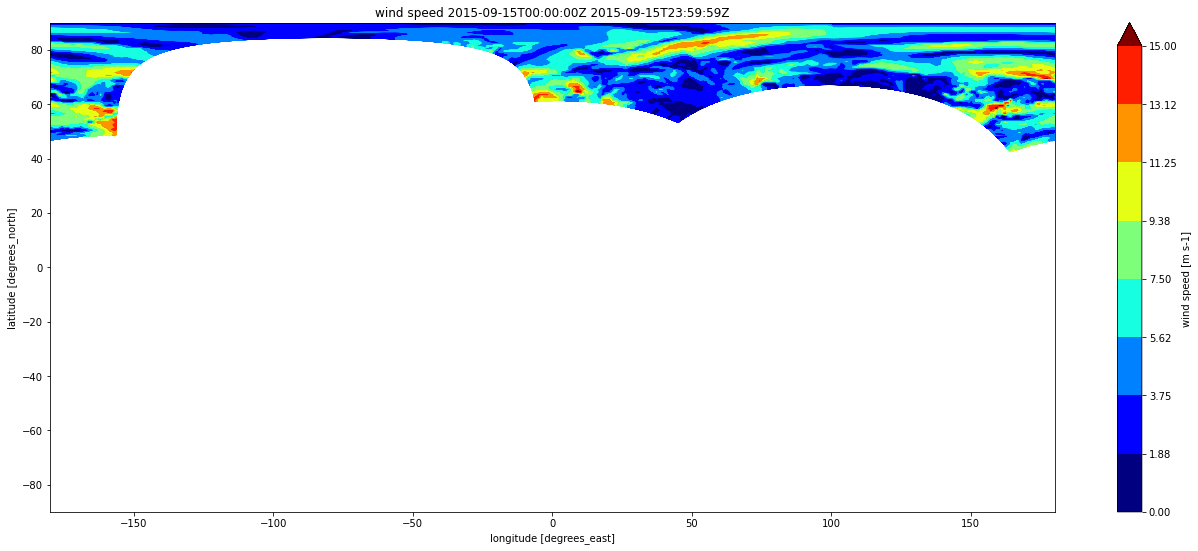

In [13]:
#plot all the stacked files
ds_stacked.plot.scatter( y="lat",
                 x="lon", 
                 hue="wind_speed",
                 s=1,
                 vmin=0,
                 vmax=15,
                 levels=9, 
                 cmap="jet",
                 aspect=2.5,
                 size=9, )

plt.title(f'wind speed {start_date} {end_date}')
plt.xlim(  -180., 180.)
plt.ylim(-90.,  90.)
plt.show()

In [14]:
#load a dataset gridded that will be our grid
dataset2='podaac-ops-cumulus-protected/OISSS_L4_multimission_7day_v1'
contents = s3_client.ls(dataset2)[0]
contents
file = s3_client.open(contents)
ds_grid = xr.open_dataset(file)
ds_grid

<xarray.Dataset>
Dimensions:          (longitude: 1440, latitude: 720, time: 1)
Coordinates:
  * longitude        (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * latitude         (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * time             (time) datetime64[ns] 2011-08-28
Data variables:
    sss              (latitude, longitude, time) float32 ...
    sss_uncertainty  (latitude, longitude, time) float32 ...
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     [0.25]
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            [-180.]
    geospatial_lon_max:            [180.]
    geospatial_lon_resolution:     [0.25]
    geospatial_lon_units:          degrees_east

In [15]:
ds_grid=ds_grid.sel(latitude=slice(latmin,latmax), longitude=slice(lonmin,lonmax))
ds_grid

<xarray.Dataset>
Dimensions:          (longitude: 200, latitude: 60, time: 1)
Coordinates:
  * longitude        (longitude) float32 -169.9 -169.6 -169.4 ... -120.4 -120.1
  * latitude         (latitude) float32 65.12 65.38 65.62 ... 79.38 79.62 79.88
  * time             (time) datetime64[ns] 2011-08-28
Data variables:
    sss              (latitude, longitude, time) float32 ...
    sss_uncertainty  (latitude, longitude, time) float32 ...
Attributes: (12/42)
    Conventions:                   CF-1.8, ACDD-1.3
    standard_name_vocabulary:      CF Standard Name Table v27
    Title:                         Multi-Mission Optimally Interpolated Sea S...
    Short_Name:                    OISSS_L4_multimission_7d_v1
    Version:                       V1.0
    Processing_Level:              Level 4
    ...                            ...
    geospatial_lat_resolution:     [0.25]
    geospatial_lat_units:          degrees_north
    geospatial_lon_min:            [-180.]
    geospatial_lon_max:            [180.]
    geospatial_lon_resolution:     [0.25]
    geospatial_lon_units:          degrees_east

In [16]:
longrid = ds_grid.longitude.values
latgrid = ds_grid.latitude.values

LOgrid, LAgrid = numpy.meshgrid(longrid, latgrid)

print(LOgrid.shape,LAgrid.shape)


(60, 200) (60, 200)


In [17]:
target = pr.SwathDefinition(LOgrid, LAgrid)

In [18]:
wind_speed = numpy.reshape(ds_stacked.wind_speed.values,(numpy.prod(ds_stacked.wind_speed.values.shape)))
lons = numpy.reshape(ds_stacked.lon.values,(numpy.prod(ds_stacked.lon.values.shape)))
lats = numpy.reshape(ds_stacked.lat.values,(numpy.prod(ds_stacked.lat.values.shape)))
lons = (lons + 180) % 360 - 180
print(wind_speed.shape, lons.shape, lats.shape)

(34508800,) (34508800,) (34508800,)


In [19]:
source = pr.SwathDefinition(lons, lats)

In [20]:
result, stddev, counts = resample_gauss(
    source,
    wind_speed,
    target,
    radius_of_influence=175000,  
    sigmas=25000,
    neighbours=100,
    fill_value=numpy.nan,
    with_uncert=True,
)
result.shape

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 175000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


(60, 200)

In [21]:
def to_xrda(data):
    return xr.DataArray(data,
                        dims=['latitude', 'longitude'], 
                        coords={'latitude': latgrid, 
                                'longitude': longrid})

In [22]:
grid = to_xrda(result)
grid

<xarray.DataArray (latitude: 60, longitude: 200)>
array([[8.68362331, 8.74477386, 8.81718826, ...,        nan,        nan,
               nan],
       [8.21124458, 8.31290054, 8.41037464, ...,        nan,        nan,
               nan],
       [7.7611866 , 7.89313555, 8.01295662, ...,        nan,        nan,
               nan],
       ...,
       [3.80543184, 3.8491323 , 3.91341853, ...,        nan,        nan,
               nan],
       [4.54188347, 4.56896162, 4.59459305, ...,        nan,        nan,
               nan],
       [5.28293133, 5.29341459, 5.30391121, ...,        nan,        nan,
               nan]])
Coordinates:
  * latitude   (latitude) float32 65.12 65.38 65.62 65.88 ... 79.38 79.62 79.88
  * longitude  (longitude) float32 -169.9 -169.6 -169.4 ... -120.6 -120.4 -120.1

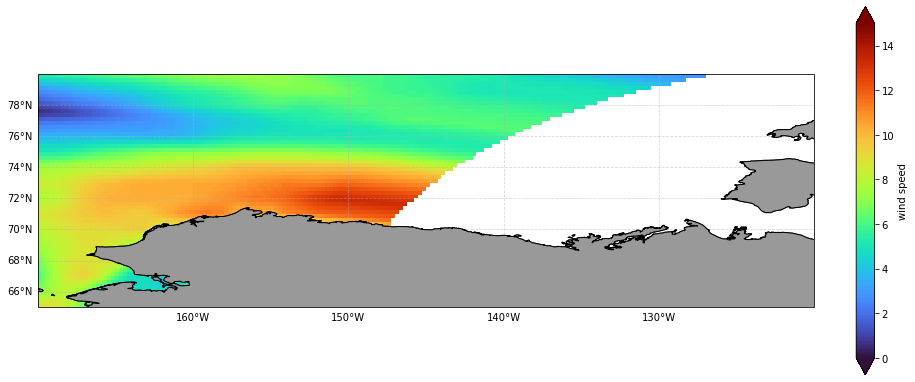

In [23]:
[LO,LA]=numpy.meshgrid(grid.longitude,grid.latitude)
fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-150))  # Orthographic
extent = [lonmin, lonmax, latmin, latmax]
ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(LO,LA,grid,vmin=0,vmax=15,transform=ccrs.PlateCarree(),shading='auto')
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('wind speed',fontsize = 10)